<a href="https://colab.research.google.com/github/zach401/acnsim_baseline_comparison/blob/master/baseline_algorithms_w_constrained_infrastructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*If running in Colab run this first to install ACN-Portal.*

In [0]:
!git clone https://github.com/zach401/acnportal.git
!pip install acnportal/.

# Baseline Algorithm Evaluation
In this experiment we compare the performance of the Round Robin, First-Come First-Served, Earliest Deadline First, and Least Laxity First algorithms. To understand how these algorithms cope with constrained infrastructure, we limit the capacity of the transformer feeding the charging network. We then compare what percentage of energy demands each algorithm is able to meet. We also consider the current unbalance caused by each algorithm to help understand why certain algorithms are able to deliver more or less energy at a given infrastrucutre capacity.

In [0]:
from matplotlib import pyplot as plt
from datetime import datetime
import pytz
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint
from copy import deepcopy

from acnportal.acnsim import Simulator
from acnportal.acnsim.network.sites import CaltechACN
from acnportal.acnsim.events import acndata_events
from acnportal.acnsim.analysis import *
from acnportal.algorithms import SortedSchedulingAlgo, UncontrolledCharging, RoundRobin
from acnportal.algorithms import earliest_deadline_first, first_come_first_served, least_laxity_first

## Experiment Parameters


In [0]:
# Timezone of the ACN we are using.
timezone = pytz.timezone('America/Los_Angeles')

# Start and End times are used when collecting data.
start = timezone.localize(datetime(2019, 3, 1))
end = timezone.localize(datetime(2019, 4, 1,))

# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 208  # volts

# Default maximum charging rate for each EV battery.
default_battery_power = 6.6  # kW
site = 'caltech'

# -- Events --------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acndata_events.generate_events(API_KEY, site, start, end, period, 
                                        voltage, default_battery_power)

## Algorithms
We consider four algorithms: Round Robin, First-Come First-Served, Earliest Deadline First, and Least Laxity First.

In [0]:
sch = {}
sch['FCFS'] = SortedSchedulingAlgo(first_come_first_served)
sch['LLF'] = SortedSchedulingAlgo(least_laxity_first)
sch['EDF'] = SortedSchedulingAlgo(earliest_deadline_first)
sch['RR'] = RoundRobin(first_come_first_served)

## Experiment
To run the experiment we vary the capacity of the transformer which feeds the Caltech charging network from 5 kW to 150 kW. This allows us to see how each algorithm copes with various levels of infrastructure constraints.

In [0]:
results = defaultdict(dict)
sims = defaultdict(dict)
for d in [5, 10, 15, 20, 25, 35, 50, 75, 100, 125, 150]:
    cn = CaltechACN(voltage=voltage, transformer_cap=d)
    for sch_alg in sch:
        sim = Simulator(deepcopy(cn), sch[sch_alg], deepcopy(events),
                        start, period=period, max_recomp=1, verbose=False)
        sim.run()
        obj = proportion_of_energy_delivered(sim)
        results[sch_alg][d] = obj
        sims[sch_alg][d] = sim

## Results
We can then analyze the results of the experiment. We consider three metrics. 

1.   Proportion of total energy requested which is delivered by each algorithm. 
2.   Maximum infrastructure utilization, defined as the maximum instantaneous power draw over the capacity of the system.
3.   Average current unbalance which measures how well each algorithm is able to balance between phases, a key factor in maximally utilizing infrastructure capacity.





In [0]:
e_del = defaultdict(dict)
un_bal = defaultdict(dict)
max_util = defaultdict(dict)
for alg in sims:
  for d in sims[alg]:
    e_del[alg][d] = proportion_of_energy_delivered(sims[alg][d]) * 100
    un_bal[alg][d] = np.nanmean(current_unbalance(sims[alg][d], ['Secondary {0}'.format(p) for p in 'ABC'], 'SYM_COMP')) * 100
    max_util[alg][d] = np.max(aggregate_current(sims[alg][d]))*voltage / 1000 / d * 100

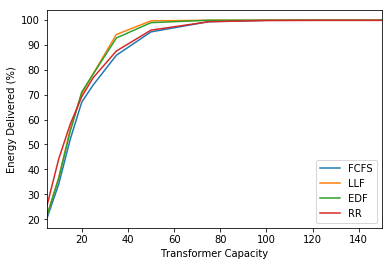

In [89]:
pd.DataFrame(e_del).plot()
plt.ylabel('Energy Delivered (%)')
plt.xlabel('Transformer Capacity')
pass

In this figure we can see that with enough infrastructure capacity, all algorithms are able to meet 100% of demand. Since these requests were taken from real charging data, they are all feasible (meaning with enough capacity we should be able to meet them), so this is to be expected. 



The most interesting range, however, in when infrastructure is moderately constrained, in this case between 30-75 kW. In this range we see that algorithms which use information about departure times and energy demands (EDF and LLF) preform significantly better than those that do not (FCFS and RR). 



Another interesting, but less practical range of operation is the highly constrained regime. Here we see that RR outperforms the other algorithms. To see why we consider the infrastructure utilization plot below.


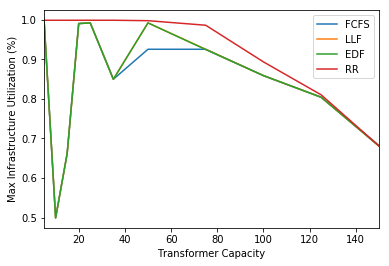

In [90]:
pd.DataFrame(max_power).plot()
plt.ylabel('Max Infrastructure Utilization (%)')
plt.xlabel('Transformer Capacity')
pass

From this plot we can see that RR does a much better job at utilizing constrained infrastructure capacity (in terms of maximum utilization) than the other algorithms. To see why, we can examine the phase unbalance plot below. 

*Note that with high enough capacity, the max utilization for all algorithms converges. This is because there is only so much instantaneous demand in the underlying requests.*

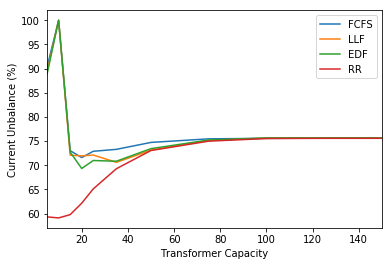

In [91]:
pd.DataFrame(un_bal).plot()
plt.ylabel('Current Unbalance (%)')
plt.xlabel('Transformer Capacity')
pass

Here we see that RR acheive much lower average current unbalance than the other algorithms, esspecailly at low infrastructure capacity. By balancing between phases RR is able to deliver power matching the capacity of the network as seen above. However, the other sorting based algorithms do not do as well balancing between phases, leading them to underutilize infrastructure capacity even when there are EVs present which could charge. 

*Note that with sufficient infrastructure capacity, all algorithms have the same average current unbalance. This is becasue the unbalance is inheriant in the demands, i.e. more energy was requested on phase A than on phase B or C.*


This explains why RR is able to deliver more energy with highly constrained infrastructure. When infrastructure is less constrained, however, RR's shortcomings in not accounting for energy demands and departure times means that some EVs are fully charged before their deadline while others leave unsatisfied. This motivates us to examine algorithms which both balance between phases and account for session information such as the adaptive scheduling algorithm presented [here](https://ieeexplore.ieee.org/document/8587550).

## Additional Visualizations
ACN-Sim also allows us to take a deeper dive into the currents in our simulations. Here we visualize the line currents on the primary and secondary side of the transformer feeding the Caltech ACN for each algorithm. 

In [0]:
currents = {}
limits = {}
cap = 15
for alg in sims:
  currents[alg] = constraint_currents(sims[alg][cap])
  currents[alg]['Total'] = aggregate_current(sims[alg][cap])
  limits[alg] = {c.name: c.limit for c in sims[alg][cap].network.constraint_set.constraints}

In [0]:
def plot_currents(name, start, length):
  fig, axes = plt.subplots(3, len(currents), sharey=True, sharex=True, figsize=(14, 8))
  fig.subplots_adjust(wspace=0.07)

  
  for i, alg in enumerate(currents):
    for j, line in enumerate('ABC'):
      axes[j, i].plot(currents[alg]['{0} {1}'.format(name, line)][start: start + length], label=line)
      axes[j, i].axhline(limits[alg]['{0} {1}'.format(name, line)], color='grey')
      
  for ax, col in zip(axes[0], currents.keys()):
    ax.set_title(col)

  for ax, row in zip(axes[:,0], ['Phase {0} Current (A)'.format(p) for p in 'ABC']):
      ax.set_ylabel(row)

  fig.tight_layout()

### Primary Currents

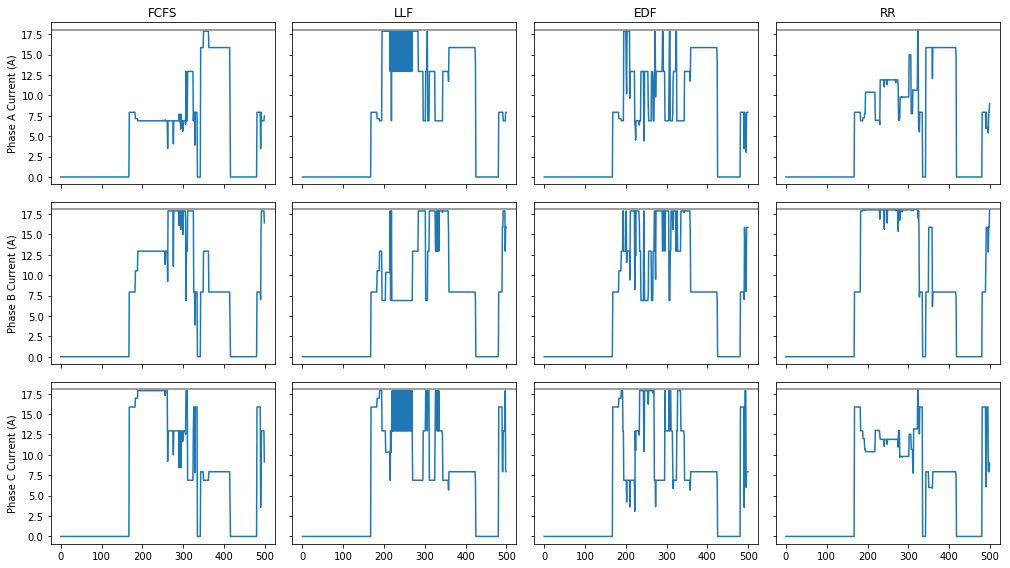

In [81]:
plot_currents('Primary', 0, 500)

### Secondary Currents

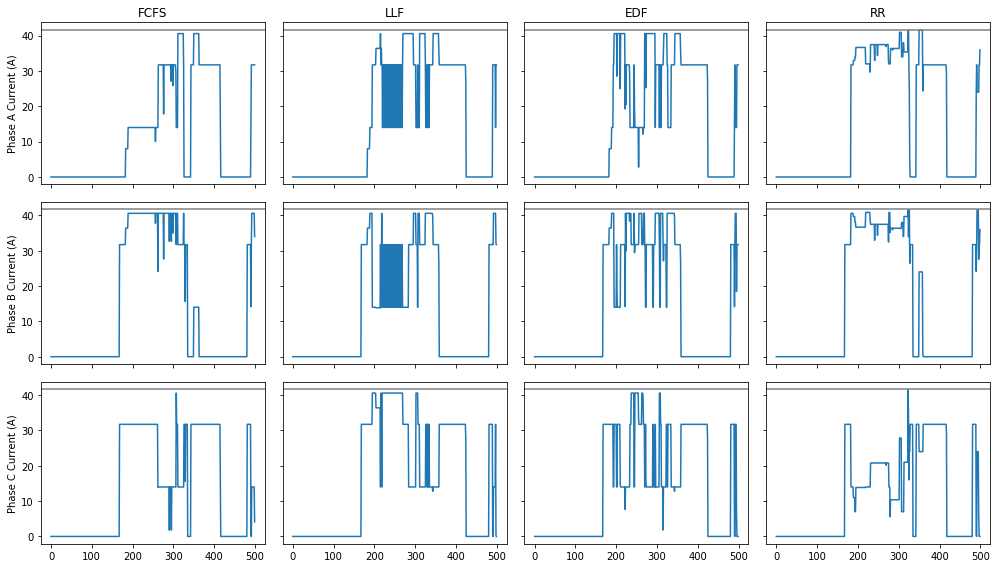

In [83]:
plot_currents('Secondary', 0, 500)